In [1]:
# First load the dielectric constant data from the VASP output
import numpy as np
from pymatgen.io.vasp.outputs import Vasprun

def symmetrise(a):
    """Turn a XX, YY, ZZ, XY, YZ, XZ array into a symmetrical 3x3 matrix"""
    return [[a[0], a[3], a[5]], [a[4], a[1], a[4]], [a[5], a[4], a[2]]]
            
vr = Vasprun('vasprun.xml')
energies, eps_real, eps_imag = vr.dielectric
eps_real = np.array([symmetrise(a) for a in eps_real])
eps_imag = np.array([symmetrise(a) for a in eps_imag])

/home/alex/dev/pymatgen/pymatgen/io/vasp/outputs.py:818: UserWarning: No POTCAR file with matching TITEL fields was found in /home/alex/dev/kkr/kramers-kronig
  " was found in {}".format(os.path.abspath(p)))


In [2]:
# python version based on code in linear_optics.F
import math

def kkr(de, eps_imag, cshift=1e-6):
    eps_imag = np.array(eps_imag)
    nedos = eps_imag.shape[0]
    eps_real = []
    for i_r in range(nedos):
        w_r = de * i_r
        total = np.zeros(eps_imag.shape[1:], dtype=np.complex_)
        
        for i_i in range(nedos):
            w_i = de * i_i
            val = eps_imag[i_i] * ((1. / (w_r - w_i - complex(0, cshift)))
                                   + (1. / (- w_r - w_i + complex(0, cshift)))) * (-0.5)
            total += val
        eps_real.append(total * (2 / math.pi) * de + np.diag([1, 1, 1]))
    return np.real(np.array(eps_real))

%timeit kkr(energies[1] - energies[0], eps_imag)

1 loop, best of 3: 19.3 s per loop


In [3]:
# improved numpy version with Adam Jackon's help
import math
import scipy.integrate

def kkr(de, eps_imag, cshift=1e-6):
    eps_imag = np.array(eps_imag)
    nedos = eps_imag.shape[0]
    cshift = complex(0, cshift)
    w_i = np.arange(0, nedos*de, de, dtype=np.complex_)
    w_i = np.reshape(w_i, (nedos, 1, 1))
    
    def integration_element(w_r):
        factor = w_i / (w_i**2 - w_r**2 + cshift)
        total = np.sum(eps_imag * factor, axis=0)
        return total * (2/math.pi) * de + np.diag([1, 1, 1])

    return np.real([integration_element(w_r) for w_r in w_i[:,0,0]])

%timeit kkr(energies[1] - energies[0], eps_imag)

1 loop, best of 3: 282 ms per loop


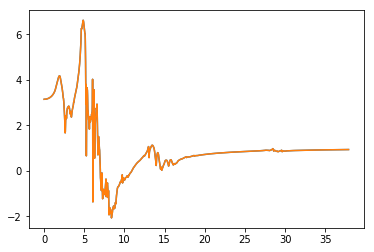

In [4]:
# check that the real dielectric constants match
%matplotlib inline
import matplotlib.pyplot as plt

eps_real_calc = kkr(energies[1] - energies[0], eps_imag)

plt.plot(energies, eps_real[:, 0, 0])
plt.plot(energies, eps_real_calc[:, 0, 0])
plt.show()